In [23]:
import numpy as np
import matplotlib.pyplot as plt
import random

class Hopfield_Net():
    """
        - X is the input matrix where each column is a sample
        - W is a matrix of the weights.
        
    """
    def __init__(self, X, bias = 0):
        self.X = X
        self.D = X.shape[0] # Number of units
        self.N = X.shape[1] # Number of patterns
        self.bias = bias
        self.avg_act = self.calc_avg_act()
        self.Wrand = np.random.normal(0,1,(self.D,self.D))
        self.W = self.init_W_avg_act()
        self.max_iter = 10
        #self.max_iter = 2750
        self.iters = 0
        self.pattern_dict = self.init_dict()
        self.attractor_dict = self.pattern_dict.copy()
        self.update_type = 'syn'
        self.store_updates = []
        self.nr_converge = 0
    
    def calc_avg_act(self):
        avg_act = 0
        for p in range(self.N):
            x = self.X[:,p]
            for i in range(self.D):
                avg_act += x[i]
        return avg_act*(1/(self.N*self.D))
    
    def init_W(self):
        W = np.zeros([self.D, self.D])
        for p in range(self.N):
            x = self.X[:,p]
            for i in range(self.D):
                for j in range(self.D):
                    W[i,j] += x[i]*x[j]
        W = W - np.diag(np.diag(W))
        return W
    
    def init_W_avg_act(self):
        W = np.zeros([self.D, self.D])
        for p in range(self.N):
            x = self.X[:,p]
            for i in range(self.D):
                for j in range(self.D):
                    W[i,j] += (x[i] - self.avg_act)*(x[j] - self.avg_act)
        W = W - np.diag(np.diag(W))
        return W
    
    def init_dict(self): # Dict of patterns as row vectors
        pattern_dict = {}
        for p in range(self.N):
            pattern = self.X[:,p].reshape(1, self.D)
            pattern_dict[p] = pattern
        return pattern_dict
    
    def update_rule(self, x): # x is a row vector
        #print("Before update {}".format(self.iters), x)
        for i in range(self.D):
            sum_term = 0
            for j in range(self.D):
                sum_term += self.W[i,j]*x[0,j]
            x[0,i] = np.sign(sum_term)
        #print("After update {}".format(self.iters), x)
        return x
    
    def sparse_update_rule(self, x):
        #print("Before update {}".format(self.iters), x)
        for i in range(self.D):
            sum_term = 0
            for j in range(self.D):
                sum_term += self.W[i,j]*x[0,j] - self.bias
            x[0,i] = 0.5 + 0.5*np.sign(sum_term)
        #print("After update {}".format(self.iters), x)
        return x

    def sparse_random_update_rule(self, x):
        #print("Before update {}".format(self.iters), x)
        i = random.choice(list(range(self.D)))
        sum_term = 0
        for j in range(self.D):
            sum_term += self.W[i,j]*x[0,j] - self.bias
        x[0,i] = 0.5 + 0.5*np.sign(sum_term)
        #print("After update {}".format(self.iters), x)
        return x
    
    def random_update_rule(self, x):
        #print("Before update {}".format(self.iters), x)
        i = random.choice(list(range(1024)))
        sum_term = 0
        for j in range(self.D):
            sum_term += self.W[i,j]*x[0,j]
        x[0,i] = np.sign(sum_term)
        #print("After update {}".format(self.iters), x)
        return x
    
    def update_W(self, x): # x is a row vector
        for i in range(self.D):
            for j in range(self.D):
                self.W[i,j] += x.T[i]*x.T[j]
        self.W = self.W - np.diag(np.diag(self.W))
        self.N += 1
        self.pattern_dict[self.N-1] = x.reshape(1, self.D)
        return self.W
    
    def add_attractor(self, x):
        self.attractor_dict[len(self.attractor_dict.keys())] = x.reshape(1, self.D)
    
    def energy(self, x):
        E = 0
        for i in range(self.D):
            for j in range(self.D):
                E += self.W[i,j]*x[0,i]*x[0,j]
        return -E

    def net_out(self, x): # x is a row vector
        #self.W = self.update_W(x)
        #if np.array_equal(x, y):
        #y = np.sign(np.dot(self.W, x.T))
        if self.update_type == 'syn':
            y = self.sparse_update_rule(np.copy(x))
            #self.store_updates.append(x)
        else:
            if self.iters % 250 == 0:
                self.store_updates.append(x) # Ta bort
            y = self.sparse_random_update_rule(np.copy(x))
        in_pattern_dict = [(y == pattern).all() 
                      for pattern in self.pattern_dict.values()]
        if any(in_pattern_dict):
            fixed_point = np.nonzero(in_pattern_dict)[0][0]
            ###print("Converged to X-row {} after {} iterations".format(fixed_point+1, self.iters+1))
            self.iters = 0
            self.nr_converge += 1
            return y
        elif np.array_equal(x, y) and self.update_type == 'syn':
            ###print("Stable after {}. Did not change after last iteration.".format(self.iters+1))
            in_attractor_dict = [(y == attractor).all() 
                      for attractor in self.attractor_dict.values()]
            if not any(in_attractor_dict):
                self.add_attractor(y)
            self.iters = 0
            return y
        elif self.iters <= self.max_iter:
            self.iters += 1
            if self.update_type == 'syn':
                return self.sparse_update_rule(self.net_out(np.copy(y)))
            else:
                return self.sparse_random_update_rule(self.net_out(np.copy(y)))
        else:
            ###print("Reached maximum number of iterations.")
            self.iters = 0
            return y
    
    #def number_of_atractors:
        
    
    #def train(self):
    #    for idx in range(self.N):
    #        x = X[:,idx].reshape([self.D, 1])
    #        y = net_out(x)

In [24]:
def sparse_pattern(dim, act_percent):
    number_of_active = round(act_percent*dim)
    act_ids = np.random.choice(list(range(dim)), number_of_active, replace = False)
    pattern = np.zeros([1, dim])
    for idx in act_ids:
        pattern[0,idx] = 1
    return pattern

In [25]:
X = sparse_pattern(100, 0.1)

In [42]:
X = sparse_pattern(100, 0.01).T
for p in range(299):
    x = sparse_pattern(100, 0.01)
    X = np.concatenate((X, x.T), axis = 1)

In [43]:
X.shape

(100, 300)

In [60]:
from tqdm import tqdm
act_percent = 0.1
X = sparse_pattern(100, act_percent).T
for p in range(299):
    x = sparse_pattern(100, act_percent)
    X = np.concatenate((X, x.T), axis = 1)

hop_net = Hopfield_Net(X)
hop_net.update_type = 'asyn'

conv_01 = []
for bias in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 2, 3, 4, 5]:
    hop_net.nr_converge = 0
    for x_id in tqdm(range(hop_net.N)):
        hop_net.bias = bias
        hop_net.net_out(np.copy(hop_net.X[:,x_id].reshape(1, hop_net.D)))
    print("Number of stored (out of 300): {}, with bias: {}".format(hop_net.nr_converge, bias))
    conv_01.append(hop_net.nr_converge)


 33%|███▎      | 98/300 [00:00<00:00, 507.05it/s]

Number of stored (out of 300): 259, with bias: 0.01


 30%|██▉       | 89/300 [00:00<00:00, 445.33it/s]

Number of stored (out of 300): 270, with bias: 0.1


 31%|███▏      | 94/300 [00:00<00:00, 483.91it/s]

Number of stored (out of 300): 278, with bias: 0.3


 12%|█▏        | 36/300 [00:00<00:00, 349.16it/s]

Number of stored (out of 300): 265, with bias: 0.5


 29%|██▉       | 88/300 [00:00<00:00, 323.42it/s]

Number of stored (out of 300): 266, with bias: 0.7


 14%|█▍        | 42/300 [00:00<00:00, 412.97it/s]

Number of stored (out of 300): 271, with bias: 0.9


 10%|█         | 31/300 [00:00<00:00, 280.07it/s]

Number of stored (out of 300): 276, with bias: 1


 25%|██▌       | 76/300 [00:00<00:00, 301.07it/s]

Number of stored (out of 300): 272, with bias: 2


 12%|█▏        | 36/300 [00:00<00:00, 320.62it/s]

Number of stored (out of 300): 266, with bias: 3


 26%|██▌       | 78/300 [00:00<00:00, 344.74it/s]

Number of stored (out of 300): 276, with bias: 4


100%|██████████| 300/300 [00:00<00:00, 421.14it/s]

Number of stored (out of 300): 269, with bias: 5


0.1 act => 249-277

In [61]:
hop_net.avg_act

0.1

In [62]:
from tqdm import tqdm
act_percent = 0.01
X = sparse_pattern(100, act_percent).T
for p in range(299):
    x = sparse_pattern(100, act_percent)
    X = np.concatenate((X, x.T), axis = 1)

hop_net = Hopfield_Net(X)
hop_net.update_type = 'asyn'

conv_001 = []
for bias in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 2, 3, 4, 5]:
    hop_net.nr_converge = 0
    for x_id in tqdm(range(hop_net.N)):
        hop_net.bias = bias
        hop_net.net_out(np.copy(hop_net.X[:,x_id].reshape(1, hop_net.D)))
    print("Number of stored (out of 300): {}, with bias: {}".format(hop_net.nr_converge, bias))
    conv_001.append(hop_net.nr_converge)


 29%|██▉       | 87/300 [00:00<00:00, 862.17it/s]

Number of stored (out of 300): 298, with bias: 0.01


 29%|██▊       | 86/300 [00:00<00:00, 853.28it/s]

Number of stored (out of 300): 298, with bias: 0.1


 64%|██████▍   | 192/300 [00:00<00:00, 948.41it/s]

Number of stored (out of 300): 297, with bias: 0.3


 30%|███       | 91/300 [00:00<00:00, 909.07it/s]

Number of stored (out of 300): 298, with bias: 0.5


 18%|█▊        | 54/300 [00:00<00:00, 475.65it/s]

Number of stored (out of 300): 298, with bias: 0.7


 44%|████▍     | 132/300 [00:00<00:00, 577.83it/s]

Number of stored (out of 300): 298, with bias: 0.9


 26%|██▌       | 77/300 [00:00<00:00, 734.40it/s]

Number of stored (out of 300): 297, with bias: 1


 53%|█████▎    | 158/300 [00:00<00:00, 811.29it/s]

Number of stored (out of 300): 296, with bias: 2


 27%|██▋       | 80/300 [00:00<00:00, 799.44it/s]

Number of stored (out of 300): 299, with bias: 3


 49%|████▉     | 148/300 [00:00<00:00, 709.76it/s]

Number of stored (out of 300): 298, with bias: 4


100%|██████████| 300/300 [00:00<00:00, 750.27it/s]

Number of stored (out of 300): 297, with bias: 5


0.01 act => 295-299

In [63]:
hop_net.avg_act

0.01

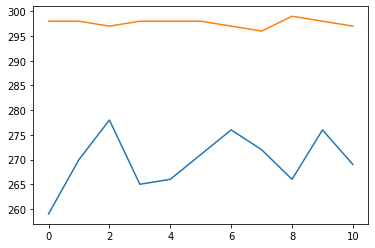

In [64]:
plt.plot(conv_01)
plt.plot(conv_001)